# Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from skimage.restoration import inpaint
from scipy.io import wavfile
from math import log10, sqrt
import csv
import os
from google.colab import files
from skimage.metrics import structural_similarity as ssim
!pip install pesq
from pesq import pesq

# Import dataset

In [ ]:
# let's try with MOBIPHONE dataset
!wget --no-check-certificate -r "https://drive.google.com/uc?export=download&id=1MflXkdaeAFyBftKkCTTuUXkfJ-fOTzus" -O "MOBIPHONE.zip"
!unzip MOBIPHONE.zip

#THEN WE WILL NEED TO RUN THE MAIN SCRIPT OVER ALL OF THE FILES IN THE DATASET

In [ ]:
test_folder = "MOBIPHONE/Vodafone joy 845/"

# Functions

In [ ]:
def convert(freq_img, ph, data, reconstruction, max_val, min_val, sr):
    inpainted_freq_rep_db = ((freq_img-0)/(255-0))*(max_val-min_val)+min_val
    inpainted_freq_rep = librosa.db_to_amplitude(inpainted_freq_rep_db)

    if data == "1": #stft
      if reconstruction == "1": #original phase
        #inpainted_freq_rep = librosa.db_to_amplitude(inpainted_freq_rep_db)
        real = inpainted_freq_rep * np.cos(ph)
        imag = inpainted_freq_rep * np.sin(ph)
        mod_freq_rep = np.zeros([len(real), len(real[0])], dtype=np.complex_)
        # inverse transform (creating a complex stft from modified magnitude and original phase)
        for i in range(len(real)):
            for j in range(len(real[0])):
                mod_freq_rep[i, j] = complex(real[i, j], imag[i, j])
          
        output = librosa.istft(mod_freq_rep, win_length=625, hop_length=625, window='rect')

      else: #griffinlim
        #inpainted_freq_rep = librosa.db_to_amplitude(inpainted_freq_rep_db)
        output = librosa.griffinlim(inpainted_freq_rep, win_length=625, hop_length=625, window='rect')

    else: #log mel
      if reconstruction == "1": #original phase
        #inpainted_freq_rep = librosa.db_to_power(inpainted_freq_rep_db)
        inpainted_freq_rep = librosa.feature.inverse.mel_to_stft(inpainted_freq_rep, sr, n_fft=1023, power=1.0)
        real = inpainted_freq_rep * np.cos(ph)
        imag = inpainted_freq_rep * np.sin(ph)
        mod_freq_rep = np.zeros([len(real), len(real[0])], dtype=np.complex_)
        # inverse transform (creating a complex stft from modified magnitude and original phase)
        for i in range(len(real)):
            for j in range(len(real[0])):
                mod_freq_rep[i, j] = complex(real[i, j], imag[i, j])
        output = librosa.istft(mod_freq_rep, win_length=625, hop_length=625, window='rect')
      
      else: #griffinlim
        #inpainted_freq_rep = librosa.db_to_power(inpainted_freq_rep_db)
        mod_freq_rep = librosa.feature.inverse.mel_to_stft(inpainted_freq_rep, sr, n_fft=1023,power=1.0)
        output = librosa.griffinlim(mod_freq_rep, win_length=625, hop_length=625, window='rect')
    
    return output

In [ ]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal .
        # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def alternative_SNR(y):

  def energy(x):
    e = np.sum(x ** 2)
    return e

  Z = librosa.stft(y, n_fft=1023, win_length=625, hop_length=625, window='rect')
  z = librosa.istft(Z, win_length=625, hop_length=625, window='rect')
  n = y[:z.size] - z
  snr = 10 * np.log10(energy(y)/energy(n))
  return snr

# Main Program

1-STFT / 2-LOG MEL SPECT
1
1-Original Phase / 2-Griffinlim
1

 ITERATION 1 - FILE 1...


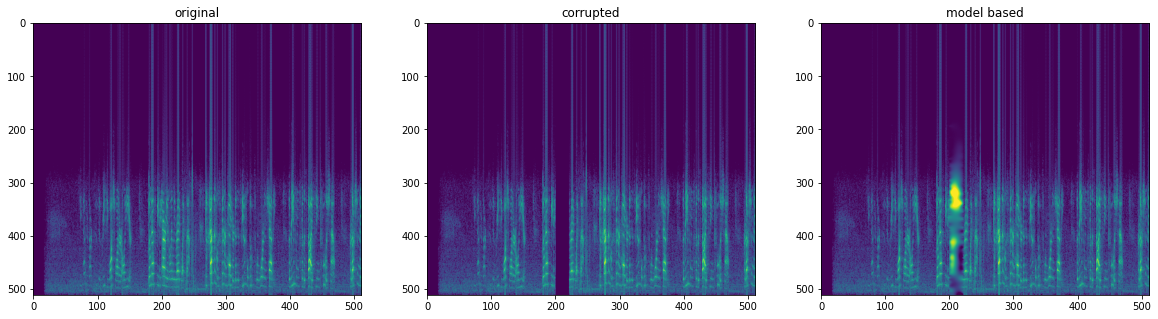


 ITERATION 1 - FILE 2...


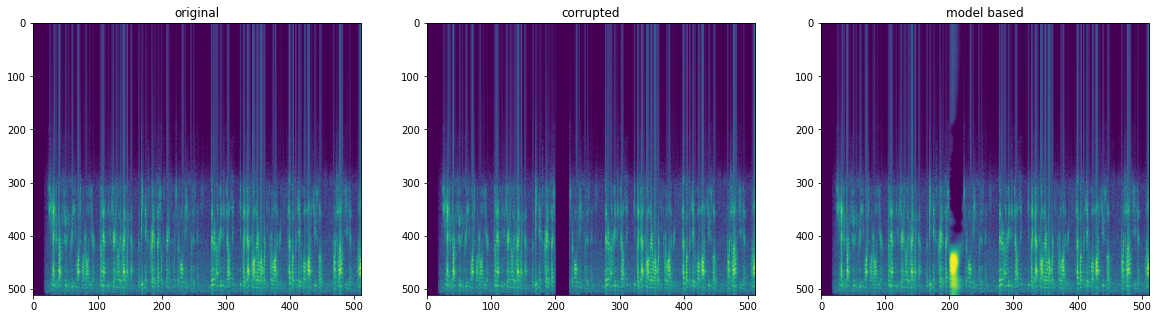


 ITERATION 1 - FILE 3...


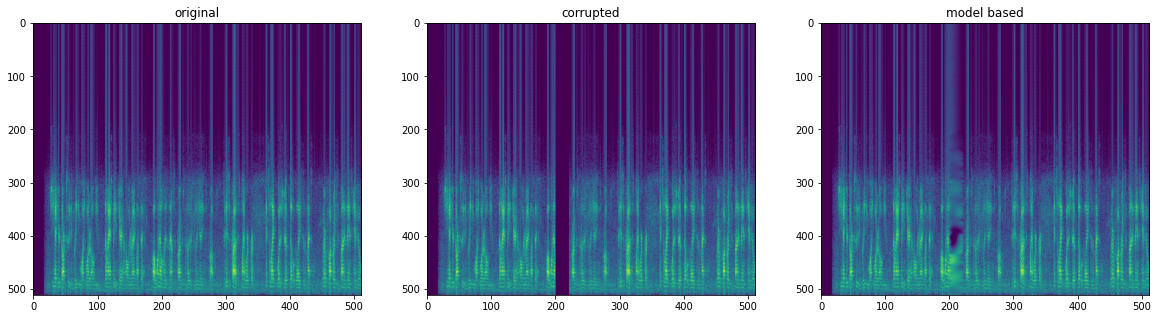

KeyboardInterrupt: ignored

In [ ]:
n_files = 24 # inside test folder
i = 1 # index of output file (progressive)
starting_point=200 # where to start mask
increment = 2 # increment given to the row/column corruption

# ask input parameters
data = input("1-STFT / 2-LOG MEL SPECT\n")
reconstruction = input("1-Original Phase / 2-Griffinlim\n")
while (data != "1" and data != "2") or (reconstruction != "1" and reconstruction != "2"):
    data = input("1-STFT / 2-LOG MEL SPECT\n")
    reconstruction = input("1-Original Phase / 2-Griffinlim\n")

for m in range(0, 10, increment):
  i = 1
  iteration = round(m/increment)+1
  # delete old csv if present
  if os.path.isfile('model_based_results_'+str(data)+'_'+str(reconstruction)+'_'+str(iteration)+'.csv'):
    os.remove('model_based_results_'+str(data)+'_'+str(reconstruction)+'_'+str(iteration)+'.csv')

  # creating csv file where to save results (SNR/PSNR)
  with open('model_based_results_'+str(data)+'_'+str(reconstruction)+'_'+str(iteration)+'.csv', mode='w') as model_based: # OPENING FILE (TILL THE END)
    model_based_writer = csv.writer(model_based, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    model_based_writer.writerow(['FILE', 'SNR', 'PSNR', 'SSIM', 'PESQ'])
    #so, for example...model_based_results_1_1.csv means results of data = 1 (stft) and reconstruction = 1 (original phase)


    for audio in sorted(os.listdir(test_folder)):
      ext = os.path.splitext(audio)[-1].lower()
      if ext == ".wav":
        y, sr = librosa.load(test_folder+audio, sr=16000)
        y = y[0:20*sr]
        if data == "1":
            freq_rep = librosa.stft(y, n_fft=1023, win_length=625, hop_length=625, window='rect')
            ph = np.angle(freq_rep)
        else:
            freq_rep = librosa.stft(y, n_fft=1023, win_length=625, hop_length=625, window='rect')
            ph = np.angle(freq_rep)
            freq_rep = librosa.feature.melspectrogram(S=abs(freq_rep), n_mels=512, sr=16000, power=1.0)
        
        # EVERY COLUMN IS 39ms
        # EVERY ROW IS 39Hz

        if data == "1":
            mag_db = librosa.amplitude_to_db(np.abs(freq_rep))
        else:
            mag_db = librosa.amplitude_to_db(freq_rep)  # mel
        
        # max and min values (in db) for conversion
        max_val = np.max(np.max(mag_db))
        min_val = np.min(np.min(mag_db))
        # converting into image
        freq_rep_img = np.round(((mag_db-min_val)/(max_val-min_val))*(255-0)+0)
        # applying mask
        mask = np.zeros([len(freq_rep_img), len(freq_rep_img[0])])

        # setting mask
        mask[starting_point:(starting_point+m+1), :] = 1
        corrupted_img = freq_rep_img.copy()
        corrupted_img[starting_point:(starting_point+m+1), :] = 0
        

        # inpainting
        inpainted_img = inpaint.inpaint_biharmonic(corrupted_img, mask, multichannel=False)

        #plotting figures
        print("\n ITERATION "+str(iteration)+" - FILE "+str(i)+"...")
        plt.subplots(1,3,figsize=(20,5))
        plt.subplot(1, 3, 1)
        plt.imshow(np.flip(freq_rep_img,axis=0), aspect='auto')
        plt.title('original')
        plt.subplot(1, 3, 2)
        plt.imshow(np.flip(corrupted_img,axis=0), aspect='auto')
        plt.title('corrupted')
        plt.subplot(1, 3, 3)
        plt.imshow(np.flip(inpainted_img,axis=0), aspect='auto')
        plt.title('after inpainting')
        plt.show()
        # converting back to stft data
        output = convert(inpainted_img, ph, data, reconstruction, max_val, min_val, sr)
        # writing output (but we'll keep just first file)
        max_o=np.max(output)
        min_o=np.min(output)
        output=((output-min_o)/(max_o-min_o))*(max(y)-min(y))+min(y) # converting back
        wavfile.write('output_'+str(i)+'_'+str(iteration)+'.wav', sr, output.astype(np.float32))

        # SNR, PSNR, PESQ
        psnr = PSNR(freq_rep_img, inpainted_img)
        o, sr = librosa.load('output_'+str(i)+'_'+str(iteration)+'.wav', sr=16000)
        snr = alternative_SNR(o)
        if i!=1:
          os.remove('output_'+str(i)+'_'+str(iteration)+'.wav')
        
        #PESQ
        psq = pesq(16000, y, o, 'wb')


        #SSIM
        images_ssim = ssim(freq_rep_img, inpainted_img, data_range=freq_rep_img.max() - inpainted_img.min())
        
        # save results in csv
        model_based_writer.writerow([os.path.basename(str(audio)), str(snr), str(psnr), str(images_ssim), str(psq)])

        i = i + 1

  # download csv
  files.download('model_based_results_'+str(data)+'_'+str(reconstruction)+'_'+str(iteration)+'.csv')